In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_fullver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'train_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_train_FNs.npy'))
    return images, labels, filenames


def load_testing():
    images = np.load(os.path.join('../Data_final_fullver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'test_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_test_FNs.npy'))
    return images, labels, filenames

In [3]:
train_images, train_labels, Fn= load_training()
test_images, test_labels, Fn= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2925 	 Test size: 643
Image size: 256x256


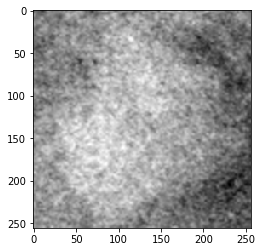

Label: 1
FN: Mass-Training_P_00106_LEFT_CC.png


In [4]:
idx = 10

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
print("FN: " + str(Fn[idx]))

In [5]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(2925, 256, 256, 1)

In [7]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [11]:
def create_inceptionv3(verbose=False, fc_size=256, output = 2, dropout=None):
    
    inceptionv3_base = InceptionV3(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    inceptionv3 = models.Sequential()
    inceptionv3.add(inceptionv3_base)

    inceptionv3.add(layers.Flatten())
    if dropout is not None:
        inceptionv3.add(layers.Dropout(dropout))
    inceptionv3.add(layers.Dense(2048, activation='relu'))
    inceptionv3.add(layers.Dense(1048, activation='relu'))
    inceptionv3.add(layers.Dense(fc_size, activation='relu'))
    inceptionv3.add(layers.Dense(output, activation='softmax'))

    # Freeze the convolutional base
    inceptionv3_base.trainable = False
    
    if verbose:
        inceptionv3_base.summary()
        inceptionv3.summary()

    return inceptionv3

In [12]:
inceptionv3 = InceptionV3(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in inceptionv3.layers:
    layer.trainable = False
inceptionv3_maxpool = inceptionv3.get_layer('mixed10').output
FeatureFlatten = Flatten()(inceptionv3_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(2, name = 'predictions', activation = 'softmax')(dense2)

new_inceptionv3 = Model(inputs = inceptionv3.input, outputs = predictions)
new_inceptionv3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
inceptionv3_calc_or_mass_best_Adam = new_inceptionv3

In [14]:
inceptionv3_calc_or_mass_best_RMSprop = new_inceptionv3

### Adam

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/inceptionv3_calc_or_mass_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

inceptionv3_calc_or_mass_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_inceptionv3_calc_or_mass_best_Adam = inceptionv3_calc_or_mass_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.7140 - recall: 0.5227
Epoch 00001: val_loss improved from inf to 3.06019, saving model to ../model/inceptionv3_calc_or_mass_best_Adam.h5
11/11 [==============================] - 29s 3s/step - loss: 1.6175 - recall: 0.5403 - val_loss: 3.0602 - val_recall: 0.5026
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5935 - recall: 0.6906
Epoch 00002: val_loss did not improve from 3.06019
11/11 [==============================] - 22s 2s/step - loss: 0.5890 - recall: 0.6967 - val_loss: 3.1750 - val_recall: 0.5368
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5857 - recall: 0.6938
Epoch 00003: val_loss did not improve from 3.06019
11/11 [==============================] - 22s 2s/step - loss: 0.5810 - recall: 0.6982 - 

Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4663 - recall: 0.7742
Epoch 00030: val_loss did not improve from 3.06019
11/11 [==============================] - 21s 2s/step - loss: 0.4690 - recall: 0.7749 - val_loss: 14.8887 - val_recall: 0.5333
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4562 - recall: 0.7963
Epoch 00031: val_loss did not improve from 3.06019
11/11 [==============================] - 21s 2s/step - loss: 0.4606 - recall: 0.7926 - val_loss: 9.5213 - val_recall: 0.5214
Epoch 00031: early stopping


In [17]:
models.save_model(inceptionv3_calc_or_mass_best_Adam, '../model/inceptionv3_calc_or_mass_end_Adam.h5')

In [18]:
tra_loss_fe = history_inceptionv3_calc_or_mass_best_Adam.history['loss']
tra_acc_fe = history_inceptionv3_calc_or_mass_best_Adam.history['recall']
val_loss_fe = history_inceptionv3_calc_or_mass_best_Adam.history['val_loss']
val_acc_fe = history_inceptionv3_calc_or_mass_best_Adam.history['val_recall']

In [19]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_inceptionv3_calc_or_mass = models.load_model('../model/inceptionv3_calc_or_mass_best_Adam.h5')
test_loss_fe, test_acc_fe = inceptionv3_calc_or_mass_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_inceptionv3_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

In [20]:
print("inceptionv3 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

inceptionv3 calc or mass

Epoch [end]: 31
Epoch [opt]: 1
Valid recall [end]: 0.5214
Valid recall [opt]: 0.5026
Test recall [end]:  0.5319
Test recall [opt]:  0.5397
Valid loss [end]: 9.5213
Valid loss [opt]: 3.0602
Test loss [end]:  9.8658
Test loss [opt]:  2.5510


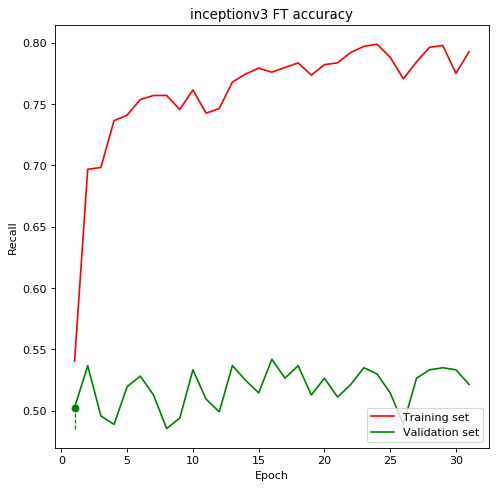

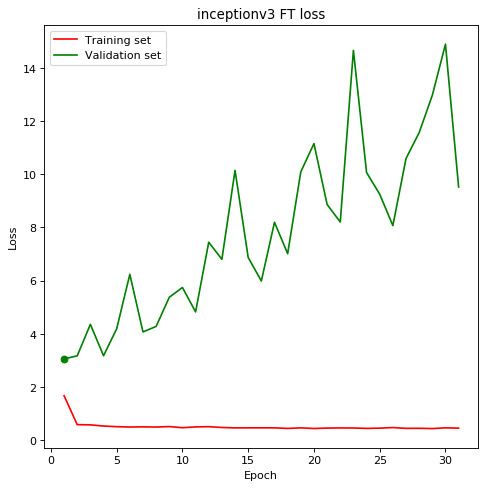

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [22]:
inceptionv3_calc_or_mass_best_SGD = create_inceptionv3(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/inceptionv3_calc_or_mass_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

inceptionv3_calc_or_mass_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [23]:
# Train
history_inceptionv3_calc_or_mass_best_SGD = inceptionv3_calc_or_mass_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9002 - recall: 0.5236
Epoch 00001: val_loss improved from inf to 7.98936, saving model to ../model/inceptionv3_calc_or_mass_best_SGD.h5
11/11 [==============================] - 24s 2s/step - loss: 0.8911 - recall: 0.5243 - val_loss: 7.9894 - val_recall: 0.5282
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7661 - recall: 0.5320
Epoch 00002: val_loss improved from 7.98936 to 6.94867, saving model to ../model/inceptionv3_calc_or_mass_best_SGD.h5
11/11 [==============================] - 23s 2s/step - loss: 0.7714 - recall: 0.5270 - val_loss: 6.9487 - val_recall: 0.5231
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7538 - recall: 0.5328
Epoch 00003: val_loss improved from 6.94867 to 5.97251, saving model to ../model/inceptionv3_calc_or_mass_best_SGD.h5
11/11 [=======================

Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6516 - recall: 0.6305
Epoch 00057: val_loss did not improve from 4.26554
11/11 [==============================] - 21s 2s/step - loss: 0.6557 - recall: 0.6229 - val_loss: 4.5776 - val_recall: 0.5009
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6441 - recall: 0.6448
Epoch 00058: val_loss did not improve from 4.26554
11/11 [==============================] - 21s 2s/step - loss: 0.6465 - recall: 0.6436 - val_loss: 4.7142 - val_recall: 0.4735
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6282 - recall: 0.6372
Epoch 00059: val_loss did not improve from 4.26554
11/11 [==============================] - 20s 2s/step - loss: 0.6314 - recall: 0.6337 - val_loss: 4.8483 - val_recall: 0.4838
Epoch 00059: early stopping


In [24]:
models.save_model(inceptionv3_calc_or_mass_best_SGD, '../model/inceptionv3_calc_or_mass_end_SGD.h5')

In [25]:
tra_loss_fe = history_inceptionv3_calc_or_mass_best_SGD.history['loss']
tra_acc_fe = history_inceptionv3_calc_or_mass_best_SGD.history['recall']
val_loss_fe = history_inceptionv3_calc_or_mass_best_SGD.history['val_loss']
val_acc_fe = history_inceptionv3_calc_or_mass_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_inceptionv3_calc_or_mass = models.load_model('../model/inceptionv3_calc_or_mass_best_SGD.h5')
test_loss_fe, test_acc_fe = inceptionv3_calc_or_mass_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_inceptionv3_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("inceptionv3 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

inceptionv3 calc or mass

Epoch [end]: 59
Epoch [opt]: 29
Valid recall [end]: 0.4838
Valid recall [opt]: 0.4906
Test recall [end]:  0.4868
Test recall [opt]:  0.4821
Valid loss [end]: 4.8483
Valid loss [opt]: 4.2655
Test loss [end]:  4.7133
Test loss [opt]:  4.6561


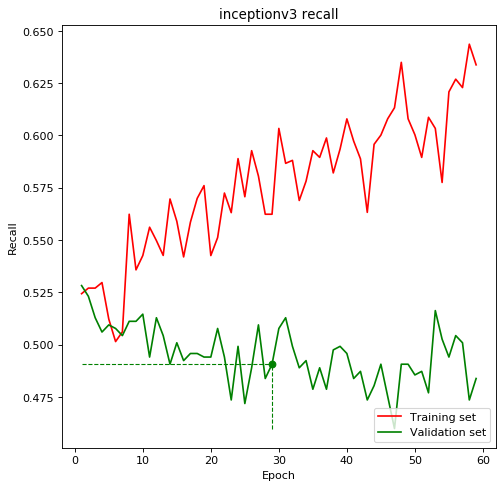

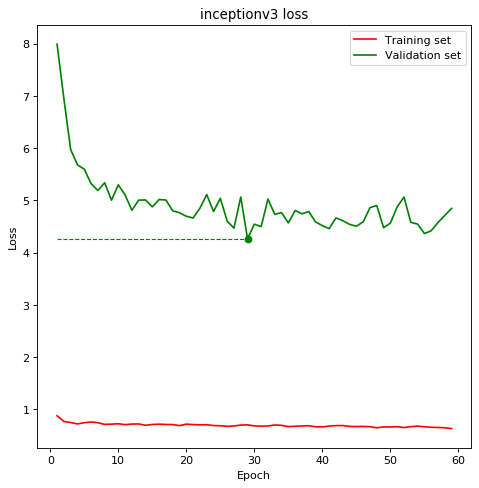

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [27]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/inceptionv3_calc_or_mass_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

inceptionv3_calc_or_mass_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [28]:
# Train
history_inceptionv3_calc_or_mass_best_RMSprop = inceptionv3_calc_or_mass_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.5274 - recall: 0.5547
Epoch 00001: val_loss improved from inf to 8.19124, saving model to ../model/inceptionv3_calc_or_mass_best_RMSprop.h5
11/11 [==============================] - 24s 2s/step - loss: 1.4371 - recall: 0.5752 - val_loss: 8.1912 - val_recall: 0.5299
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6393 - recall: 0.6469
Epoch 00002: val_loss improved from 8.19124 to 3.10501, saving model to ../model/inceptionv3_calc_or_mass_best_RMSprop.h5
11/11 [==============================] - 22s 2s/step - loss: 0.6391 - recall: 0.6506 - val_loss: 3.1050 - val_recall: 0.4803
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6173 - recall: 0.6727
Epoch 00003: val_loss did not improve from 3.10501
11/11 [==============================] - 21s 2s/step - loss: 0.6181 - recall: 0.6755 - va

In [29]:
models.save_model(inceptionv3_calc_or_mass_best_RMSprop, '../model/inceptionv3_calc_or_mass_end_RMSprop.h5')

In [30]:
tra_loss_fe = history_inceptionv3_calc_or_mass_best_RMSprop.history['loss']
tra_acc_fe = history_inceptionv3_calc_or_mass_best_RMSprop.history['recall']
val_loss_fe = history_inceptionv3_calc_or_mass_best_RMSprop.history['val_loss']
val_acc_fe = history_inceptionv3_calc_or_mass_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_inceptionv3_calc_or_mass = models.load_model('../model/inceptionv3_calc_or_mass_best_RMSprop.h5')
test_loss_fe, test_acc_fe = inceptionv3_calc_or_mass_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_inceptionv3_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("inceptionv3 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

inceptionv3 calc or mass

Epoch [end]: 32
Epoch [opt]: 2
Valid recall [end]: 0.5350
Valid recall [opt]: 0.4803
Test recall [end]:  0.5241
Test recall [opt]:  0.4899
Valid loss [end]: 19.3452
Valid loss [opt]: 3.1050
Test loss [end]:  18.2253
Test loss [opt]:  3.2482


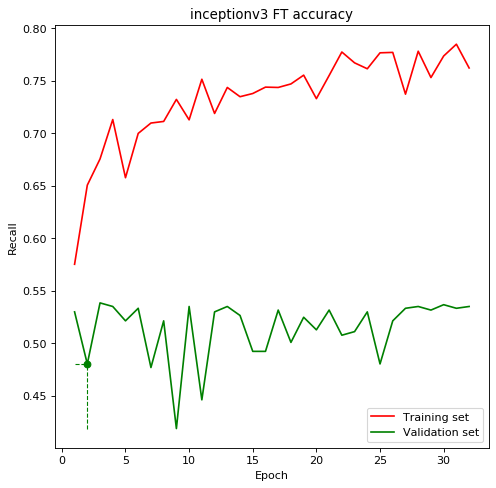

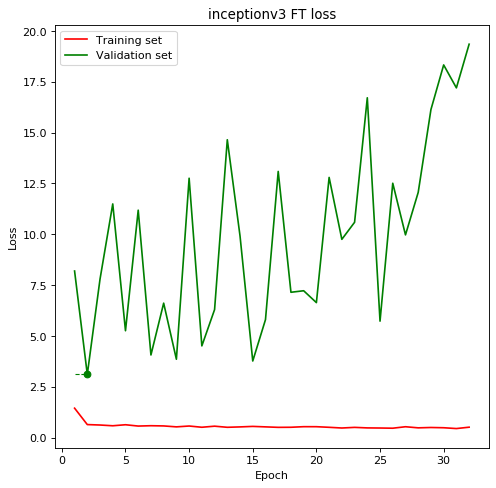

In [31]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [13]:
inceptionv3_calc_or_mass_best_Adadelta = create_inceptionv3(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/inceptionv3_calc_or_mass_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

inceptionv3_calc_or_mass_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_inceptionv3_calc_or_mass_best_Adadelta = inceptionv3_calc_or_mass_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0444 - recall: 0.5211
Epoch 00001: val_loss improved from inf to 8.14433, saving model to ../model/inceptionv3_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 29s 3s/step - loss: 1.0306 - recall: 0.5270 - val_loss: 8.1443 - val_recall: 0.5350
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9429 - recall: 0.5133
Epoch 00002: val_loss improved from 8.14433 to 7.08105, saving model to ../model/inceptionv3_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 24s 2s/step - loss: 0.9336 - recall: 0.5192 - val_loss: 7.0810 - val_recall: 0.5333
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9249 - recall: 0.5244
Epoch 00003: val_loss improved from 7.08105 to 6.53867, saving

Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7319 - recall: 0.5305
Epoch 00027: val_loss did not improve from 2.94146
11/11 [==============================] - 21s 2s/step - loss: 0.7321 - recall: 0.5327 - val_loss: 3.1808 - val_recall: 0.5077
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7267 - recall: 0.5500
Epoch 00028: val_loss did not improve from 2.94146
11/11 [==============================] - 20s 2s/step - loss: 0.7262 - recall: 0.5494 - val_loss: 3.3234 - val_recall: 0.4598
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7568 - recall: 0.4907
Epoch 00029: val_loss did not improve from 2.94146
11/11 [==============================] - 20s 2s/step - loss: 0.7542 - recall: 0.4962 - val_loss: 3.2958 - val_recall: 0.4684
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7160 - recall: 0.5572
Epoch 00030: val_loss improved from 2.94146 to 2.81125, saving model to ../model/inceptionv3_cal

Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7019 - recall: 0.5750
Epoch 00057: val_loss did not improve from 2.74907
11/11 [==============================] - 21s 2s/step - loss: 0.7032 - recall: 0.5746 - val_loss: 3.0591 - val_recall: 0.4838
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7136 - recall: 0.5741
Epoch 00058: val_loss did not improve from 2.74907
11/11 [==============================] - 20s 2s/step - loss: 0.7108 - recall: 0.5752 - val_loss: 3.0800 - val_recall: 0.4769
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7131 - recall: 0.5539
Epoch 00059: val_loss did not improve from 2.74907
11/11 [==============================] - 21s 2s/step - loss: 0.7087 - recall: 0.5561 - val_loss: 3.1628 - val_recall: 0.4752
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6997 - recall: 0.5547
Epoch 00060: val_loss did not improve from 2.74907
11/11 [==============================] - 20s 

In [15]:
models.save_model(inceptionv3_calc_or_mass_best_Adadelta, '../model/inceptionv3_calc_or_mass_end_Adadelta.h5')

In [16]:
tra_loss_fe = history_inceptionv3_calc_or_mass_best_Adadelta.history['loss']
tra_acc_fe = history_inceptionv3_calc_or_mass_best_Adadelta.history['recall']
val_loss_fe = history_inceptionv3_calc_or_mass_best_Adadelta.history['val_loss']
val_acc_fe = history_inceptionv3_calc_or_mass_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_inceptionv3_calc_or_mass = models.load_model('../model/inceptionv3_calc_or_mass_best_Adadelta.h5')
test_loss_fe, test_acc_fe = inceptionv3_calc_or_mass_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_inceptionv3_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("inceptionv3 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

inceptionv3 calc or mass

Epoch [end]: 103
Epoch [opt]: 73
Valid recall [end]: 0.4650
Valid recall [opt]: 0.4923
Test recall [end]:  0.4946
Test recall [opt]:  0.4946
Valid loss [end]: 3.3104
Valid loss [opt]: 2.6833
Test loss [end]:  3.1248
Test loss [opt]:  3.2073


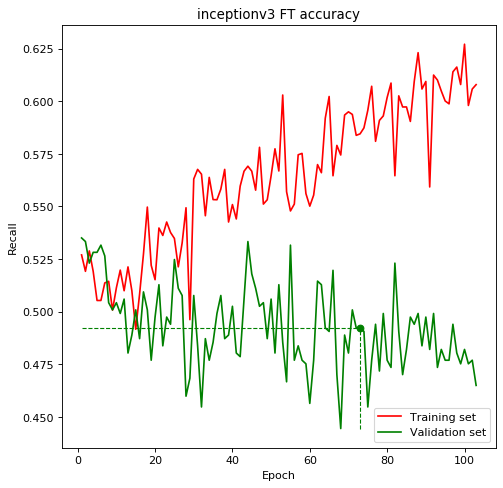

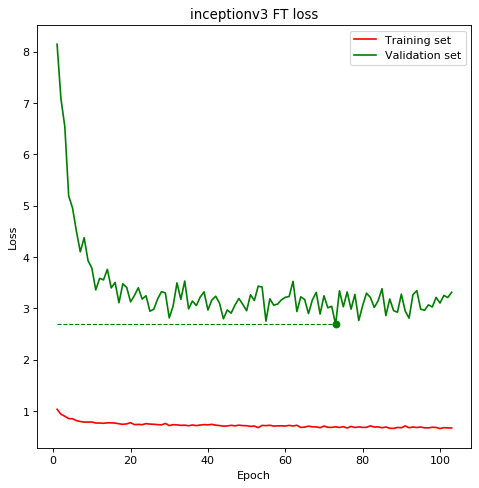

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [13]:
inceptionv3_calc_or_mass_best_Adagrad = create_inceptionv3(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/inceptionv3_calc_or_mass_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

inceptionv3_calc_or_mass_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_inceptionv3_calc_or_mass_best_Adagrad = inceptionv3_calc_or_mass_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7681 - recall: 0.4983
Epoch 00001: val_loss improved from inf to 3.89575, saving model to ../model/inceptionv3_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 27s 2s/step - loss: 0.7688 - recall: 0.4947 - val_loss: 3.8958 - val_recall: 0.5111
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7470 - recall: 0.5242
Epoch 00002: val_loss improved from 3.89575 to 3.01741, saving model to ../model/inceptionv3_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 23s 2s/step - loss: 0.7433 - recall: 0.5291 - val_loss: 3.0174 - val_recall: 0.5009
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7317 - recall: 0.5446
Epoch 00003: val_loss did not improve from 3.01741
11/11 [======

10/11 [==========================>...] - ETA: 1s - loss: 0.5995 - recall: 0.6922
Epoch 00058: val_loss did not improve from 2.43073
11/11 [==============================] - 21s 2s/step - loss: 0.5998 - recall: 0.6960 - val_loss: 3.0460 - val_recall: 0.5094
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5970 - recall: 0.6898
Epoch 00059: val_loss did not improve from 2.43073
11/11 [==============================] - 20s 2s/step - loss: 0.5862 - recall: 0.6915 - val_loss: 3.0139 - val_recall: 0.5265
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5904 - recall: 0.7008
Epoch 00060: val_loss did not improve from 2.43073
11/11 [==============================] - 21s 2s/step - loss: 0.5871 - recall: 0.6996 - val_loss: 3.2017 - val_recall: 0.4701
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5957 - recall: 0.6875
Epoch 00061: val_loss did not improve from 2.43073
11/11 [==============================] - 20s 2s/step - los

In [15]:
models.save_model(inceptionv3_calc_or_mass_best_Adagrad, '../model/inceptionv3_calc_or_mass_end_Adagrad.h5')

In [16]:
tra_loss_fe = history_inceptionv3_calc_or_mass_best_Adagrad.history['loss']
tra_acc_fe = history_inceptionv3_calc_or_mass_best_Adagrad.history['recall']
val_loss_fe = history_inceptionv3_calc_or_mass_best_Adagrad.history['val_loss']
val_acc_fe = history_inceptionv3_calc_or_mass_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_inceptionv3_calc_or_mass = models.load_model('../model/inceptionv3_calc_or_mass_best_Adagrad.h5')
test_loss_fe, test_acc_fe = inceptionv3_calc_or_mass_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_inceptionv3_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("inceptionv3 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

inceptionv3 calc or mass

Epoch [end]: 67
Epoch [opt]: 37
Valid recall [end]: 0.5026
Valid recall [opt]: 0.5265
Test recall [end]:  0.5086
Test recall [opt]:  0.5132
Valid loss [end]: 3.0655
Valid loss [opt]: 2.4307
Test loss [end]:  3.0339
Test loss [opt]:  2.7035


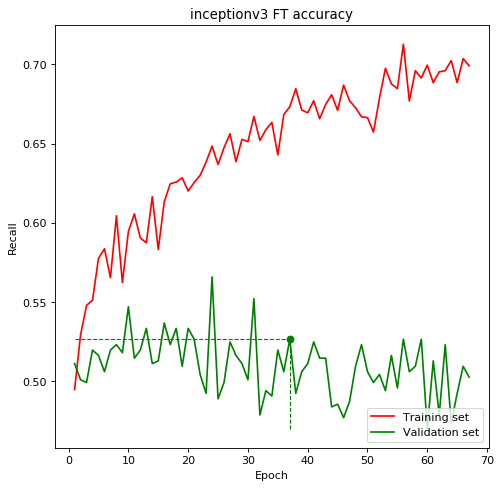

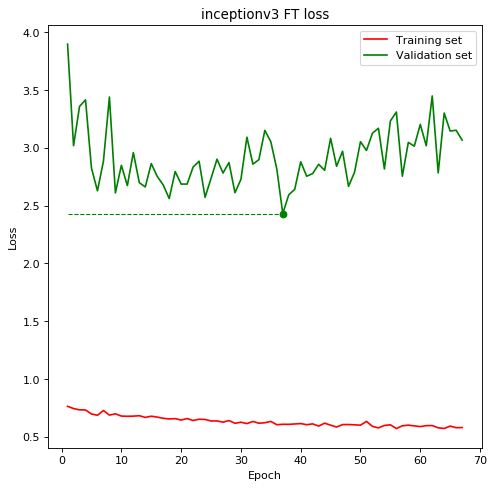

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [18]:
inceptionv3_calc_or_mass_best_Adamax = create_inceptionv3(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/inceptionv3_calc_or_mass_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

inceptionv3_calc_or_mass_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [19]:
# Train
history_inceptionv3_calc_or_mass_best_Adamax = inceptionv3_calc_or_mass_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0992 - recall: 0.5312
Epoch 00001: val_loss improved from inf to 4.34198, saving model to ../model/inceptionv3_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 27s 2s/step - loss: 1.0600 - recall: 0.5369 - val_loss: 4.3420 - val_recall: 0.5350
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6194 - recall: 0.6562
Epoch 00002: val_loss did not improve from 4.34198
11/11 [==============================] - 21s 2s/step - loss: 0.6121 - recall: 0.6565 - val_loss: 7.5676 - val_recall: 0.5350
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6098 - recall: 0.6843
Epoch 00003: val_loss did not improve from 4.34198
11/11 [==============================] - 20s 2s/step - loss: 0.6057 - recall: 0.6854 - val_loss: 5.5473 - val_recall: 0.5060
Epoch 4/300
10/11 [=================

In [20]:
models.save_model(inceptionv3_calc_or_mass_best_Adamax, '../model/inceptionv3_calc_or_mass_end_Adamax.h5')

In [13]:
opt_inceptionv3_calc_or_mass = models.load_model('../model/inceptionv3_calc_or_mass_best_Adamax.h5')
inceptionv3_calc_or_mass_best_Adamax = models.load_model('../model/inceptionv3_calc_or_mass_end_Adamax.h5')
test_loss_fe, test_acc_fe = inceptionv3_calc_or_mass_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_inceptionv3_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("inceptionv3 calc or mass\n")

print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

inceptionv3 calc or mass

Test recall [end]:  0.5179
Test recall [opt]:  0.5241
Test loss [end]:  8.8536
Test loss [opt]:  4.1586


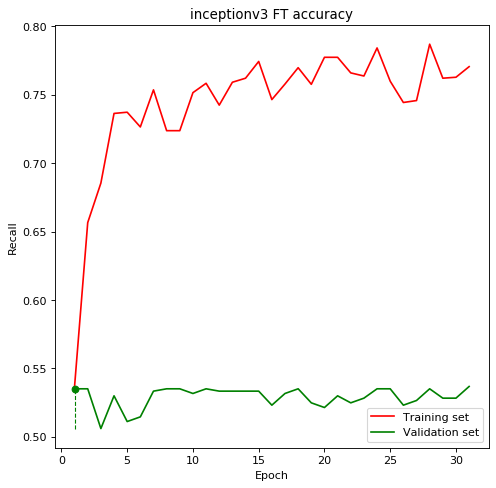

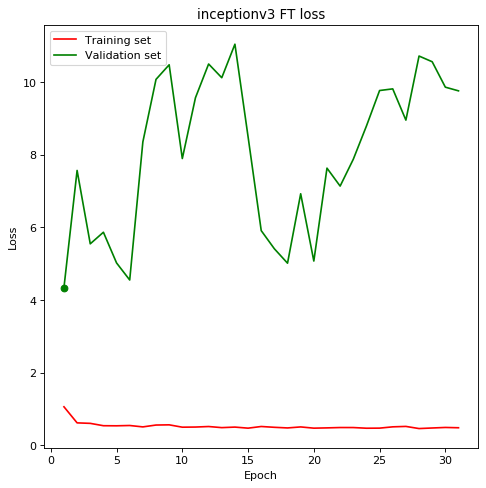

In [22]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [15]:
inceptionv3_calc_or_mass_best_Nadam = create_inceptionv3(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/inceptionv3_calc_or_mass_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

inceptionv3_calc_or_mass_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_inceptionv3_calc_or_mass_best_Nadam = inceptionv3_calc_or_mass_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.8164 - recall: 0.4742
Epoch 00001: val_loss improved from inf to 1.05772, saving model to ../model/inceptionv3_calc_or_mass_best_Nadam.h5
11/11 [==============================] - 28s 3s/step - loss: 1.7169 - recall: 0.4766 - val_loss: 1.0577 - val_recall: 0.5590
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6542 - recall: 0.5976
Epoch 00002: val_loss did not improve from 1.05772
11/11 [==============================] - 19s 2s/step - loss: 0.6479 - recall: 0.6094 - val_loss: 5.9645 - val_recall: 0.5350
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6567 - recall: 0.6103
Epoch 00003: val_loss did not improve from 1.05772
11/11 [==============================] - 19s 2s/step - loss: 0.6535 - recall: 0.6109 -

Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4488 - recall: 0.8005
Epoch 00030: val_loss did not improve from 1.05772
11/11 [==============================] - 20s 2s/step - loss: 0.4395 - recall: 0.8100 - val_loss: 8.4157 - val_recall: 0.5385
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4500 - recall: 0.7652
Epoch 00031: val_loss did not improve from 1.05772
11/11 [==============================] - 20s 2s/step - loss: 0.4450 - recall: 0.7705 - val_loss: 7.0117 - val_recall: 0.5265
Epoch 00031: early stopping


In [17]:
models.save_model(inceptionv3_calc_or_mass_best_Nadam, '../model/inceptionv3_calc_or_mass_end_Nadam.h5')

In [18]:
tra_loss_fe = history_inceptionv3_calc_or_mass_best_Nadam.history['loss']
tra_acc_fe = history_inceptionv3_calc_or_mass_best_Nadam.history['recall']
val_loss_fe = history_inceptionv3_calc_or_mass_best_Nadam.history['val_loss']
val_acc_fe = history_inceptionv3_calc_or_mass_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_inceptionv3_calc_or_mass = models.load_model('../model/inceptionv3_calc_or_mass_best_Nadam.h5')
test_loss_fe, test_acc_fe = inceptionv3_calc_or_mass_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_inceptionv3_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("inceptionv3 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

inceptionv3 calc or mass

Epoch [end]: 31
Epoch [opt]: 1
Valid recall [end]: 0.5265
Valid recall [opt]: 0.5590
Test recall [end]:  0.5257
Test recall [opt]:  0.5412
Valid loss [end]: 7.0117
Valid loss [opt]: 1.0577
Test loss [end]:  6.8863
Test loss [opt]:  0.9854


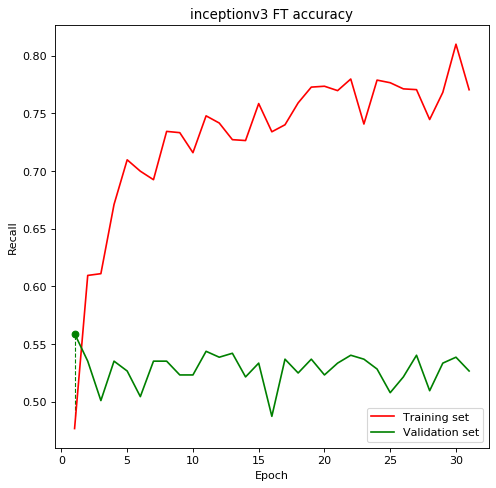

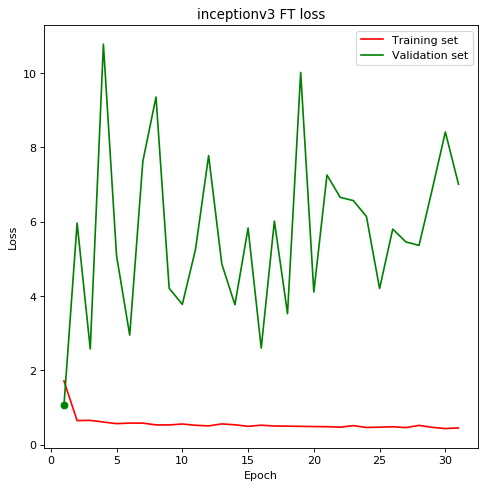

In [19]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [ ]:
inceptionv3_calc_or_mass_fine_Adam = models.load_model('../model/inceptionv3_calc_or_mass_best_Adam.h5')

for layer in inceptionv3_calc_or_mass_fine_Adam.layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
inceptionv3_calc_or_mass_fine_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

inceptionv3_calc_or_mass_fine_Adam.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/inceptionv3_calc_or_mass_fine_Adam_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [ ]:
history_fit = inceptionv3_calc_or_mass_fine_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

In [ ]:
models.save_model(inceptionv3_calc_or_mass_fine_Adam, '../model/inceptionv3_calc_or_mass_fine_Adam_end.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_inceptionv3_calc_or_mass_fine_Adam = models.load_model('../model/inceptionv3_calc_or_mass_fine_Adam_best.h5')
test_loss_fe, test_acc_fe = inceptionv3_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_inceptionv3_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)

print("inceptionv3 recall Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
inceptionv3_calc_or_mass_fine_Adam2 = models.load_model('../model/inceptionv3_calc_or_mass_fine_Adam_best.h5')

for layer in inceptionv3_calc_or_mass_fine_Adam2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
inceptionv3_calc_or_mass_fine_Adam2.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

inceptionv3_calc_or_mass_fine_Adam2.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/inceptionv3_calc_or_mass_fine_Adam_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [ ]:
history_fit = inceptionv3_calc_or_mass_fine_Adam2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

In [ ]:
models.save_model(inceptionv3_calc_or_mass_fine_Adam2, '../model/inceptionv3_calc_or_mass_fine_Adam_end2.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_inceptionv3_calc_or_mass_fine_Adam2 = models.load_model('../model/inceptionv3_calc_or_mass_fine_Adam_best2.h5')
test_loss_fe, test_acc_fe = inceptionv3_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_inceptionv3_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)

print("inceptionv3 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
inceptionv3_calc_or_mass_fine_Adam3 = models.load_model('../model/inceptionv3_calc_or_mass_fine_Adam_best2.h5')

for layer in inceptionv3_calc_or_mass_fine_Adam3.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
inceptionv3_calc_or_mass_fine_Adam3.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

inceptionv3_calc_or_mass_fine_Adam3.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/inceptionv3_calc_or_mass_fine_Adam_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [ ]:
history_fit = inceptionv3_calc_or_mass_fine_Adam3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

In [ ]:
models.save_model(inceptionv3_calc_or_mass_fine_Adam3, '../model/inceptionv3_calc_or_mass_fine_Adam_end3.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_inceptionv3_calc_or_mass_fine_Adam3 = models.load_model('../model/inceptionv3_calc_or_mass_fine_Adam_best3.h5')
test_loss_fe, test_acc_fe = inceptionv3_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_inceptionv3_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)

print("inceptionv3 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();